### Import library

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import cv2

### Download data from kaggle

1. Upload your Kaggle API token

In [8]:
from google.colab import files
files.upload()  # select the kaggle.json file to upload it (upload Kaggle access token)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sheepcore","key":"d1b43c444f53cc130d2cf805f70bb8fc"}'}

2. Set up the Kaggle API

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

3. Use the Kaggle API to download the dataset

In [10]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection

 99% 425M/431M [00:06<00:00, 80.2MB/s]
100% 431M/431M [00:06<00:00, 72.3MB/s]


4. Unzip dataset

In [ ]:
!unzip real-and-fake-face-detection.zip

### Data Visualization

In [12]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

In [13]:
real = "/content/real_and_fake_face/training_real/"
fake = "/content/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

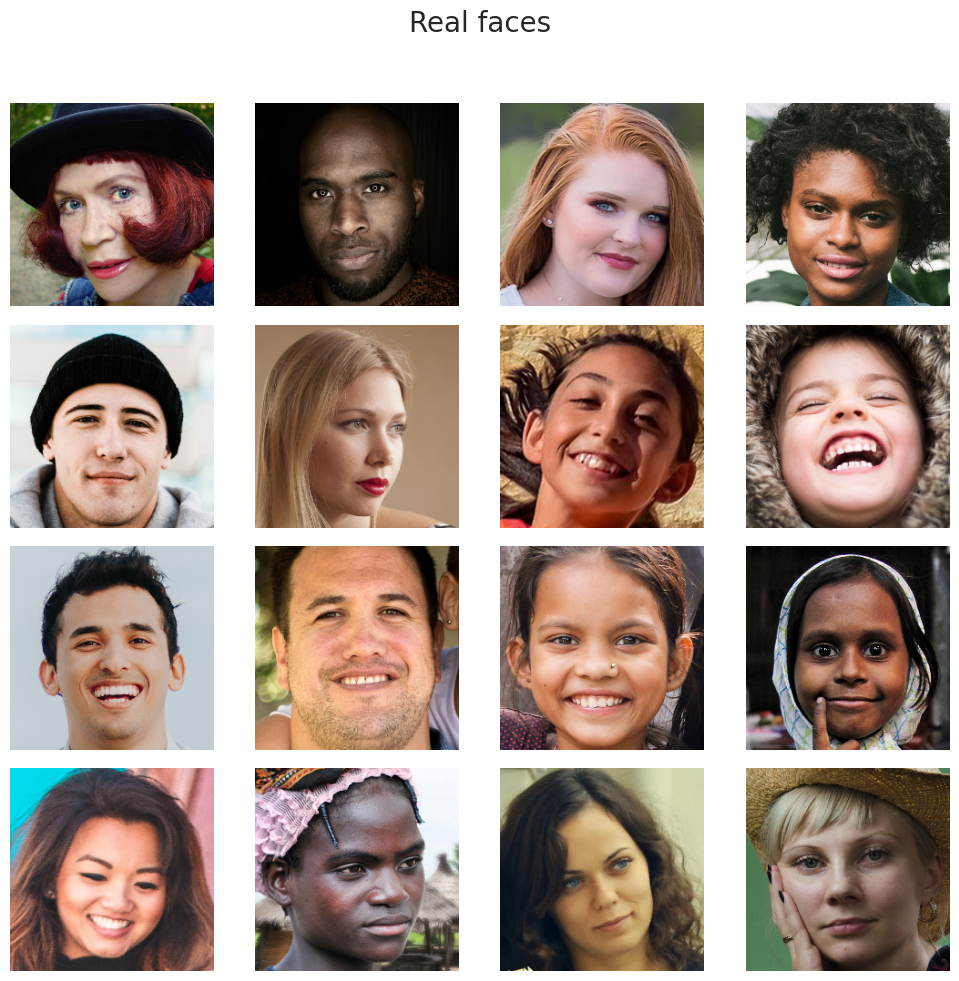

In [14]:
fig = plt.figure(figsize=(10, 10), dpi=100)
sns.set(style="white")

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

# Adjust layout to prevent overlapping of subplot titles and ticks
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

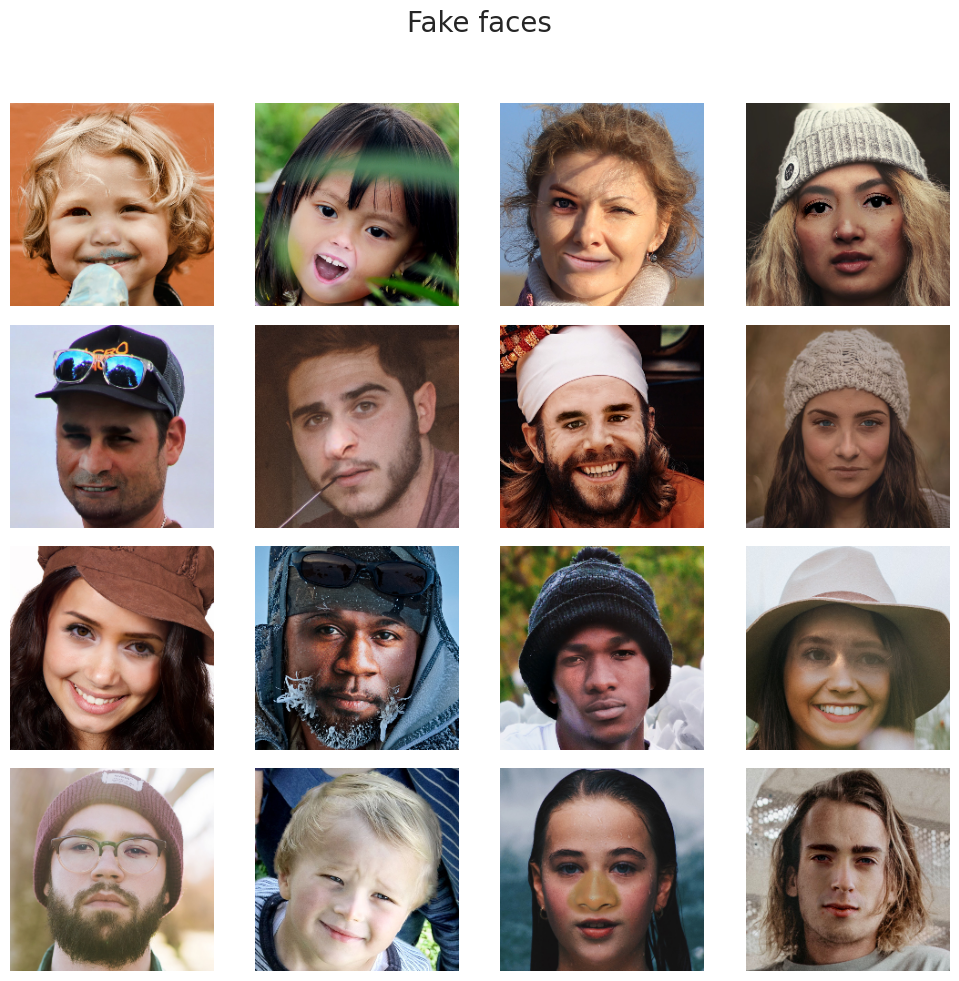

In [15]:
fig = plt.figure(figsize=(10, 10), dpi=100)
sns.set(style="white")

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fake faces",fontsize=20)
    plt.axis('off')

# Adjust layout to prevent overlapping of subplot titles and ticks
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Data Augumentation

##### Define transformations



In [16]:
# Define transformations, make sure the normalization is matched with the pre-trained model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#### Split data into training and test

In [17]:
dataset_path = "/content/real_and_fake_face/"

# Load the dataset and apply the transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split into train and test sets with a ratio of 4:1
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create data loaders for both training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model building

In [18]:
# Define Customer MobileNetV2
class CustomerMobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Load a pre-trained MobileNetV2 model
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        # Replace the classifier with a new one for our face dataset
        self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [19]:
def calculate_loss_accuracy(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Inference mode, gradient is not needed
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)  # Multiply by batch size for total loss

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    final_loss = running_loss / total_predictions
    final_accuracy = correct_predictions / total_predictions
    return final_loss, final_accuracy

### Training

In [109]:
def fit(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Initialize lists to keep track of metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        # Training loop with tqdm progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train_predictions += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

        # Calculate and store training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train_predictions / total_train_predictions
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = calculate_loss_accuracy(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

In [114]:
# Plot loss and accuracy
def plot_loss_accuracy(train_loss, train_accuracy, val_loss, val_accuracy):
    epochs = range(len(train_loss))
    plt.figure(figsize=(10, 5), dpi=100)

    # Convert accuracies to percentages
    train_accuracy = [accuracy * 100 for accuracy in train_accuracy]
    val_accuracy = [accuracy * 100 for accuracy in val_accuracies]

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'orange', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'orange', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [111]:
# Instantiate the model
model = CustomerMobileNetV2(num_classes=2)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the fit function and get the accuracy list for plotting
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    num_epochs=50,
    device=device
)

Epoch 1/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.2180, Training Accuracy: 0.91
Validation Loss: 1.1731, Validation Accuracy: 0.64


Epoch 6/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0555, Training Accuracy: 0.98
Validation Loss: 1.3912, Validation Accuracy: 0.68


Epoch 11/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0633, Training Accuracy: 0.97
Validation Loss: 1.6266, Validation Accuracy: 0.67


Epoch 16/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0385, Training Accuracy: 0.99
Validation Loss: 1.5549, Validation Accuracy: 0.68


Epoch 21/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0772, Training Accuracy: 0.97
Validation Loss: 1.3876, Validation Accuracy: 0.65


Epoch 26/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0081, Training Accuracy: 1.00
Validation Loss: 1.8110, Validation Accuracy: 0.69


Epoch 31/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0686, Training Accuracy: 0.98
Validation Loss: 1.5674, Validation Accuracy: 0.66


Epoch 36/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0076, Training Accuracy: 1.00
Validation Loss: 1.6764, Validation Accuracy: 0.67


Epoch 41/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0003, Training Accuracy: 1.00
Validation Loss: 1.7154, Validation Accuracy: 0.65


Epoch 46/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0003, Training Accuracy: 1.00
Validation Loss: 1.7736, Validation Accuracy: 0.66


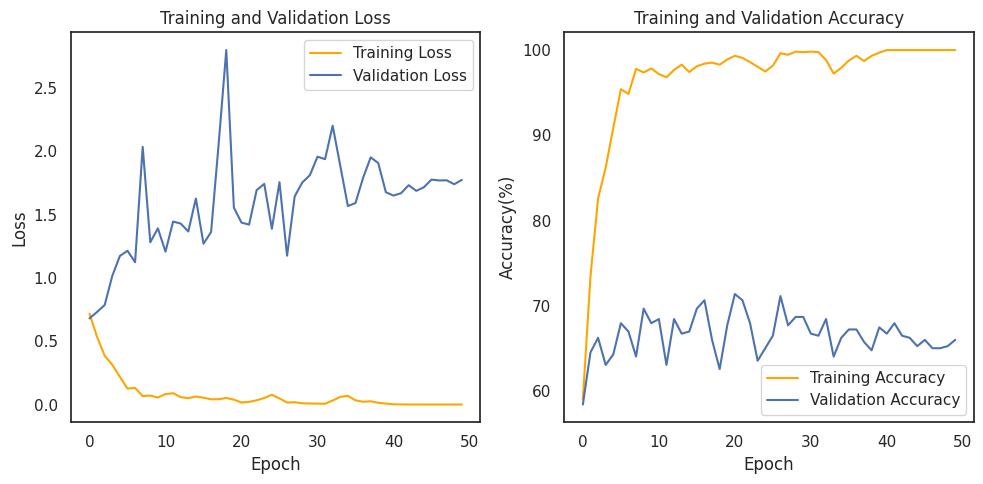

In [115]:
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

In [116]:
class GramBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(GramBlock, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def gram_matrix(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        G = G.view(a, b, c, d)  # reshape back to original shape
        return G.div(a * b * c * d)

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.gram_matrix(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class GramNet(nn.Module):
    def __init__(self, GramBlock, layers, image_channels, num_classes):
        super(GramNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # GramNet layers
        self.layer1 = self._create_layer(GramBlock, layers[0], out_channels=64, stride=1)
        self.layer2 = self._create_layer(GramBlock, layers[1], out_channels=128, stride=2)
        self.layer3 = self._create_layer(GramBlock, layers[2], out_channels=256, stride=2)
        self.layer4 = self._create_layer(GramBlock, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)  # flatten the output
        x = self.fc(x)
        return x

    def _create_layer(self, GramBlock, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4))
        layers.append(GramBlock(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(GramBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [117]:
def GramNet50(img_channels=3, num_classes=1000):
    return GramNet(GramBlock, [3, 4, 6, 3], img_channels, num_classes)


def GramNet101(img_channels=3, num_classes=1000):
    return GramNet(GramBlock, [3, 4, 23, 3], img_channels, num_classes)


def GramNet152(img_channels=3, num_classes=1000):
    return GramNet(GramBlock, [3, 8, 36, 3], img_channels, num_classes)

In [118]:
# Instantiate the model
model = GramNet50(img_channels=3, num_classes=2)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the fit function and get the accuracy list for plotting
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    num_epochs=30,
    device=device
)

Epoch 1/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/30]
Training Loss: 0.7180, Training Accuracy: 0.53
Validation Loss: 3.6788, Validation Accuracy: 0.51


Epoch 6/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10/30]
Training Loss: 0.7181, Training Accuracy: 0.54
Validation Loss: 1.3395, Validation Accuracy: 0.50


Epoch 11/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [15/30]
Training Loss: 0.7031, Training Accuracy: 0.52
Validation Loss: 0.7429, Validation Accuracy: 0.43


Epoch 16/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [20/30]
Training Loss: 0.6968, Training Accuracy: 0.54
Validation Loss: 0.7091, Validation Accuracy: 0.50


Epoch 21/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [25/30]
Training Loss: 0.6921, Training Accuracy: 0.56
Validation Loss: 0.8387, Validation Accuracy: 0.47


Epoch 26/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [30/30]
Training Loss: 0.6774, Training Accuracy: 0.59
Validation Loss: 0.7418, Validation Accuracy: 0.51


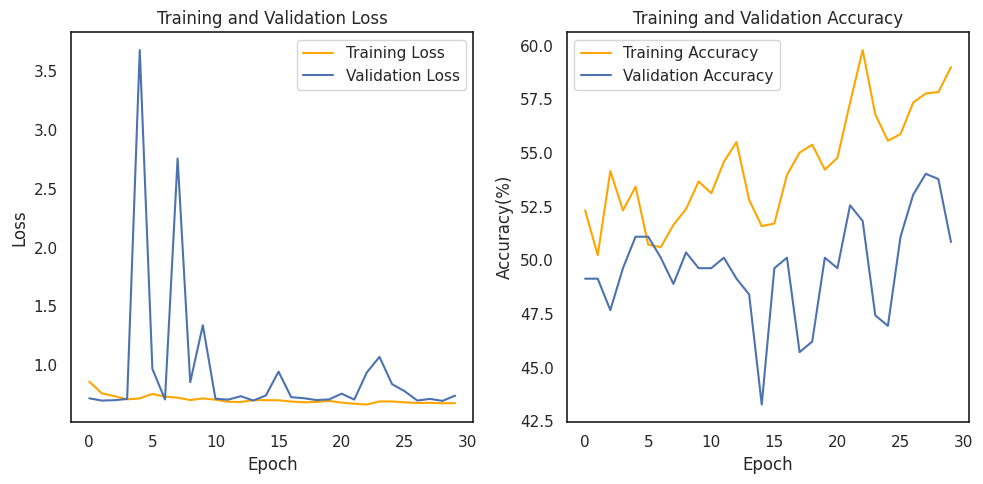

In [119]:
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)